## Step 3: Develop models

**Project**: Predicting Bus Ridership \
**Team**: T20 - Eurus Li, Garrett Kent, Kate Munkacsy

### A. Initial setup

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.evaluate.time_series import GroupTimeSeriesSplit, plot_splits # source: https://rasbt.github.io/mlxtend/user_guide/evaluate/GroupTimeSeriesSplit/

### B. Import feature data

In [5]:
data = pd.read_csv("Data/feature_matrix.csv")
data['date'] = data['year'].astype(str) + '-' + data['month'].astype(str).str.pad(2, 'left', '0')
data.head()

,route,current_garage,day_type,lagged_total_precip,lagged_avg_temp,year,month,lagged_avg_riders,season,num_unique_stops,num_unique_stops_with_shelter,covid,avg_riders,date
0,1,Ross,SAT.,3.43,33.6,2017,1,NaN,Winter,224.0,17.0,0,969.50,2017-01
1,1,Ross,SAT.,3.54,34.6,2017,2,969.50,Winter,224.0,17.0,0,1238.75,2017-02
2,1,Ross,SAT.,1.46,40.6,2017,3,1238.75,Spring,224.0,17.0,0,1178.25,2017-03
3,1,Ross,SAT.,5.02,39.9,2017,4,1178.25,Spring,224.0,17.0,0,1285.20,2017-04
4,1,Ross,SAT.,3.54,57.3,2017,5,1285.20,Spring,224.0,17.0,0,1235.50,2017-05


### C. Prepare date chunking for train-test splits

In [7]:
## Sort by date
df_sorted = data.sort_values('date')
df_sorted = df_sorted.set_index('date')
df_sorted.head()

,route,current_garage,day_type,lagged_total_precip,lagged_avg_temp,year,month,lagged_avg_riders,season,num_unique_stops,num_unique_stops_with_shelter,covid,avg_riders
date,,,,,,,,,,,,,
2017-01,1,Ross,SAT.,3.43,33.6,2017,1,NaN,Winter,224.0,17.0,0,969.500000
2017-01,74,East Liberty,SAT.,3.43,33.6,2017,1,NaN,Winter,177.0,6.0,0,392.000000
2017-01,74,East Liberty,WEEKDAY,3.43,33.6,2017,1,NaN,Winter,177.0,6.0,0,874.590909
2017-01,75,East Liberty,SAT.,3.43,33.6,2017,1,NaN,Winter,157.0,13.0,0,1783.500000
2017-01,75,East Liberty,SUN.,3.43,33.6,2017,1,NaN,Winter,157.0,13.0,0,1111.200000


In [37]:
## specify chunks for time series splits
cv_args = {"test_size": 1, "n_splits": 10}
tscv = GroupTimeSeriesSplit(**cv_args)
months = np.sort(df_sorted.index)
months

array(['2017-01', '2017-01', '2017-01', ..., '2024-10', '2024-10',
       '2024-10'], dtype=object)

### D. Establish feature and outcome dataframes

In [25]:
## establish feature and target dataframes
X = df_sorted.drop(['avg_riders'], axis = 1)
y = df_sorted['avg_riders']

## drop sparse columns
sparse_columns = list(X.columns[X.nunique() / len(X) * 100 < 0.01])
X = X.drop(sparse_columns, axis = 1)

C:\Users\Kate Munkacsy\anaconda3\Lib\site-packages\mlxtend\evaluate\time_series.py:335: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


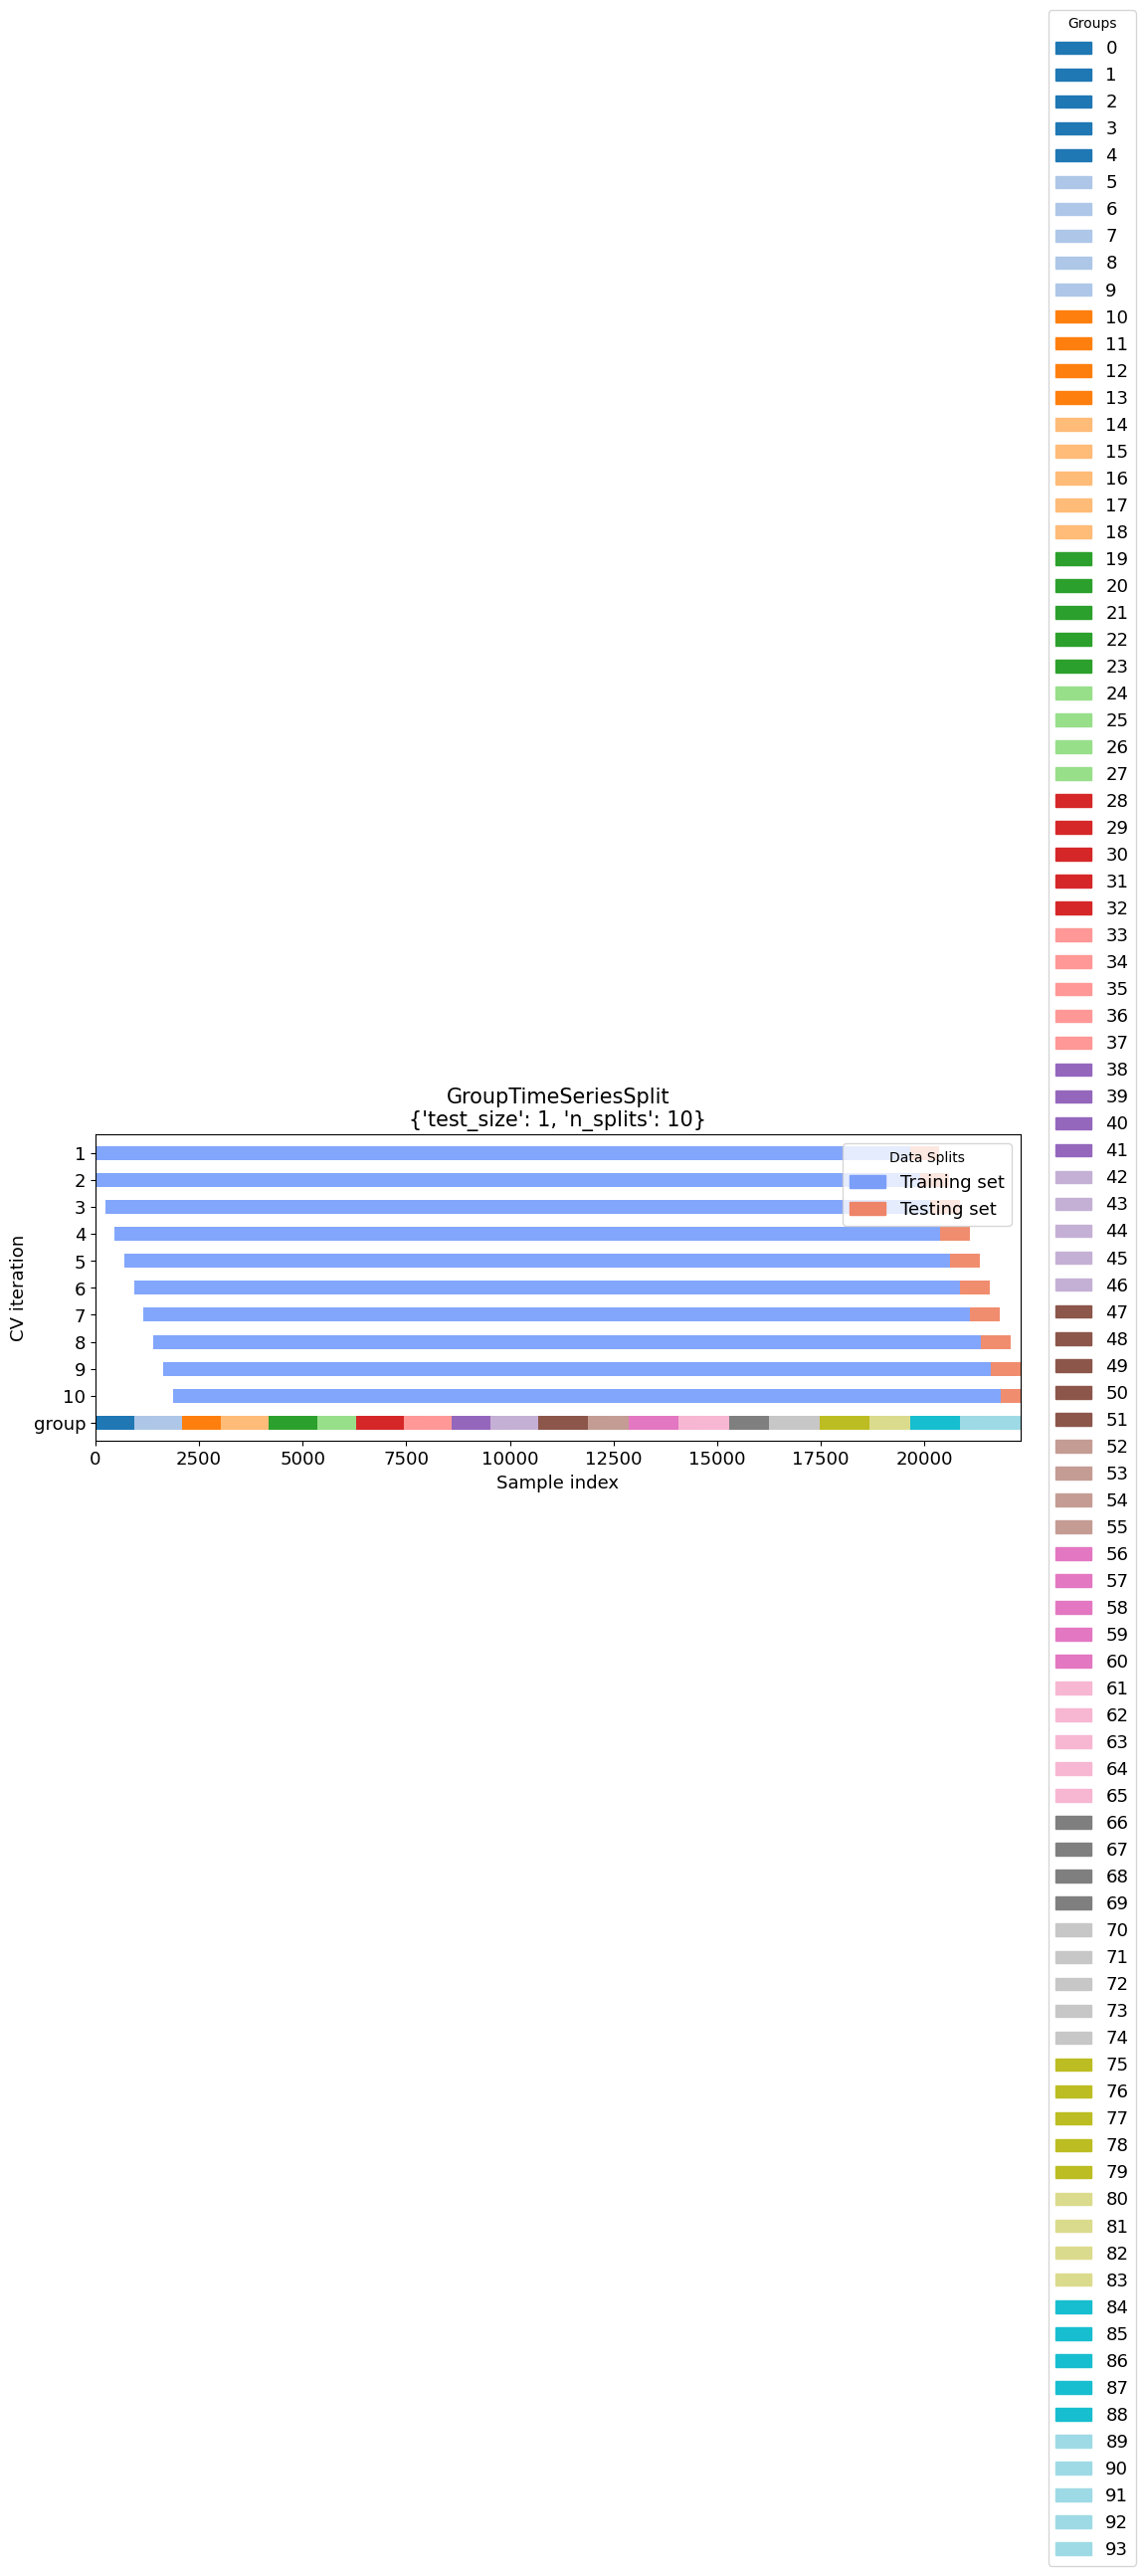

In [45]:
groups = [np.where(np.array(list(dict.fromkeys(months)))==e)[0][0]for e in months]
plot_splits(X, y, groups, **cv_args)

### E. Establish preprocessing and model details

In [28]:
def preprocess_steps(X):
    # Identify column types
    int_cols = X.select_dtypes(include='int').columns.tolist()
    float_cols = X.select_dtypes(include='float').columns.tolist()
    cat_cols = X.select_dtypes(include='object').columns.tolist()

    # Preprocessing
    numeric_preprocessor = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    categorical_preprocessor = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer([
        ('num', numeric_preprocessor, int_cols + float_cols),
        ('cat', categorical_preprocessor, cat_cols)
    ])
    
    # Define XGBoost and LightGBM pipelines
    models = {
        "Baseline (Mean)": DummyRegressor(strategy='mean'),
        "Linear Regression": Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', LinearRegression())
        ]),
        "Random Forest": Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', RandomForestRegressor(n_estimators=25, random_state=47, n_jobs=-1))
        ]),
        'XGBoost': Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
        ]),
        'LightGBM': Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
        ])
    }
    return models

### F. Fit models

In [39]:
models = preprocess_steps(X)
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv = tscv, groups = months, scoring = 'neg_root_mean_squared_error', n_jobs = -1)
    rmse_scores = -scores
    print(f"{name:<20} | Mean RMSE: {rmse_scores.mean():>10,.3f} | Std: {rmse_scores.std():.3f}")
print("")

Baseline (Mean)      | Mean RMSE:  1,040.458 | Std: 80.941
Linear Regression    | Mean RMSE:    280.342 | Std: 148.014
Random Forest        | Mean RMSE:    272.081 | Std: 134.029
XGBoost              | Mean RMSE:    267.368 | Std: 138.848
LightGBM             | Mean RMSE:    253.843 | Std: 149.861

